In [ ]:
%%writefile requirements.txt
torch==2.2.1
torchvision==0.17.1
onnx==1.16
onnxruntime-gpu==1.17
tqdm

Writing requirements.txt


In [ ]:
!git config --global user.name "GrobovoyDanil"
!git config --global user.email "grobovoydanil@gmail.com"

In [ ]:
!git clone https://github.com/GrobovoyDanil/cv-lab-pytorch-onnx.git

Cloning into 'cv-lab-pytorch-onnx'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 15 (delta 4), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (15/15), 4.36 KiB | 4.36 MiB/s, done.
Resolving deltas: 100% (4/4), done.


In [ ]:
%cd cv-lab-pytorch-onnx


[Errno 2] No such file or directory: 'cv-lab-pytorch-onnx'
/content/cv-lab-pytorch-onnx


In [ ]:
!git status

On branch main
Your branch is behind 'origin/main' by 3 commits, and can be fast-forwarded.
  (use "git pull" to update your local branch)

nothing to commit, working tree clean


In [ ]:
!git reset --hard HEAD~3
!git push origin HEAD --force

fatal: ambiguous argument 'HEAD~3': unknown revision or path not in the working tree.
Use '--' to separate paths from revisions, like this:
'git <command> [<revision>...] -- [<file>...]'
fatal: could not read Username for 'https://github.com': No such device or address


In [ ]:
!pip install -q torch torchvision onnxruntime-gpu tqdm onnx

In [ ]:
import torch, torchvision, time, onnx, onnxruntime, numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

gpu_name = torch.cuda.get_device_name(0)
gpu_memory = torch.cuda.get_device_properties(0).total_memory / (1024 ** 3)  # Перевод в ГБ

# gpu отчет
import os
markdown_content = f"""
Имя GPU - {gpu_name}
Объём VRAM - {gpu_memory:.2f}
"""
os.makedirs("docs", exist_ok=True)

with open("docs/gpu_info.md", "w", encoding="utf-8") as f:
    f.write(markdown_content)

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_ds = datasets.CIFAR10(root="data", train=True,  download=True, transform=transform)
val_ds   = datasets.CIFAR10(root="data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=64, shuffle=False, num_workers=2)

#
model = torchvision.models.efficientnet_b3(pretrained=True)
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, 10)
model = model.to(device)

from tqdm import tqdm   # pip install tqdm

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

def accuracy(net, loader):
    net.eval()
    correct = total = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            correct += (net(x).argmax(1) == y).sum().item()
            total   += y.size(0)
    return correct/total

for epoch in range(3):
    model.train()
    # оборачиваем именно тренировочный loader
    with tqdm(train_loader, desc=f"Epoch {epoch+1}") as pbar:
        for x, y in pbar:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            loss = criterion(model(x), y)
            loss.backward()
            optimizer.step()

            # обновляем строку прогресса текущим лоссом
            pbar.set_postfix(loss=loss.item())

    # после эпохи — метрика
    print(f"Epoch {epoch+1}  val-acc={accuracy(model, val_loader):.3f}")

def pytorch_inference_time(net, loader, batches=1000):
    net.eval()
    torch.cuda.synchronize()
    t0 = time.time()
    with torch.no_grad():
        for i, (x, _) in enumerate(loader):
            if i == batches: break
            x = x.to(device)
            _ = net(x)
        torch.cuda.synchronize()
    return time.time() - t0

def onnx_inference_time(sess, loader, batches=1000):
    input_name  = sess.get_inputs()[0].name
    torch.cuda.synchronize() if device.type=="cuda" else None
    t0 = time.time()
    for i, (x, _) in enumerate(loader):
        if i == batches: break
        x = x.numpy()
        _ = sess.run(None, {input_name: x})
    torch.cuda.synchronize() if device.type=="cuda" else None
    return time.time() - t0


# 7а) PyTorch
pytorch_gpu_time = pytorch_inference_time(model, val_loader)
print(f"PyTorch GPU: {pytorch_gpu_time:.2f} с")

# 7б) ONNX Runtime GPU
ort_session_gpu = onnxruntime.InferenceSession(onnx_path,
                providers=["CUDAExecutionProvider"])
onnx_gpu_time = onnx_inference_time(ort_session_gpu, val_loader)
print(f"ONNX  GPU:   {onnx_gpu_time:.2f} с")

# 7в) ONNX Runtime CPU
ort_session_cpu = onnxruntime.InferenceSession(onnx_path,
                providers=["CPUExecutionProvider"])
onnx_cpu_time = onnx_inference_time(ort_session_cpu, val_loader)
print(f"ONNX  CPU:   {onnx_cpu_time:.2f} с")

import pandas as pd
df = pd.DataFrame({
    "Framework": ["PyTorch-GPU", "ONNX-GPU", "ONNX-CPU"],
    "Time (s)":  [pytorch_gpu_time, onnx_gpu_time, onnx_cpu_time],
    "Speed-up vs PT": [1.,
                       pytorch_gpu_time/onnx_gpu_time,
                       pytorch_gpu_time/onnx_cpu_time]
})
print(df.round(2))

Device: cuda


KeyboardInterrupt: 

Device: cuda


100%|██████████| 170M/170M [00:03<00:00, 43.0MB/s]
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 159MB/s]
Epoch 1: 100%|██████████| 782/782 [04:14<00:00,  3.07it/s, loss=0.0461]


Epoch 1  val-acc=0.948


Epoch 2: 100%|██████████| 782/782 [04:15<00:00,  3.06it/s, loss=0.0346]


Epoch 2  val-acc=0.954


Epoch 3: 100%|██████████| 782/782 [04:15<00:00,  3.07it/s, loss=0.204]


Epoch 3  val-acc=0.958


Epoch 4: 100%|██████████| 782/782 [04:14<00:00,  3.07it/s, loss=0.139]


Epoch 4  val-acc=0.957


Epoch 5: 100%|██████████| 782/782 [04:15<00:00,  3.06it/s, loss=0.487]


Epoch 5  val-acc=0.954


Epoch 6: 100%|██████████| 782/782 [04:15<00:00,  3.06it/s, loss=0.0134]


Epoch 6  val-acc=0.955


Epoch 7: 100%|██████████| 782/782 [04:15<00:00,  3.06it/s, loss=0.537]


Epoch 7  val-acc=0.958


Epoch 8: 100%|██████████| 782/782 [04:15<00:00,  3.07it/s, loss=0.58]


Epoch 8  val-acc=0.956


Epoch 9: 100%|██████████| 782/782 [04:15<00:00,  3.07it/s, loss=0.00471]


Epoch 9  val-acc=0.959


Epoch 10: 100%|██████████| 782/782 [04:15<00:00,  3.06it/s, loss=0.0488]


Epoch 10  val-acc=0.959


FileNotFoundError: [Errno 2] No such file or directory: 'docs/accuracy_plot.png'

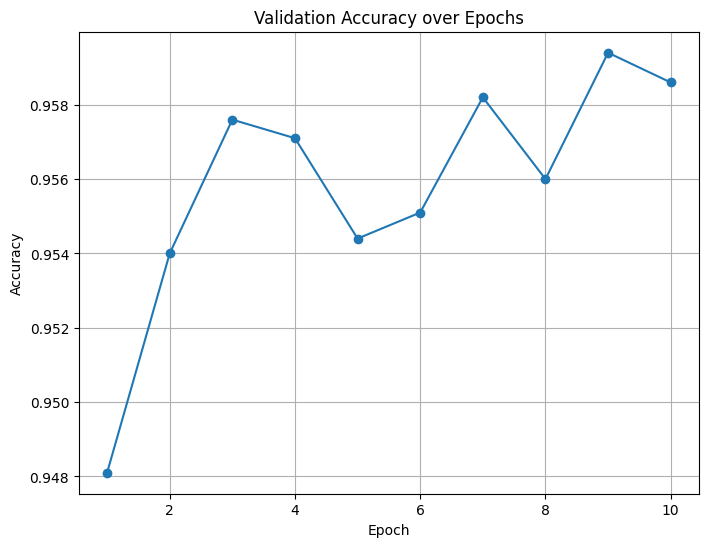

In [ ]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# трансформы
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_ds = datasets.CIFAR10(root="data", train=True, download=True, transform=transform)
val_ds = datasets.CIFAR10(root="data", train=False, download=True, transform=transform)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=2)

# сразу шлепнул b0, ибо не молодею
model = torchvision.models.efficientnet_b0(pretrained=True)
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, 10)
model = model.to(device)

# оптимизатор и лосс
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

def accuracy(net, loader):
    net.eval()
    correct = total = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            correct += (net(x).argmax(1) == y).sum().item()
            total += y.size(0)
    return correct / total

val_accuracies = []
for epoch in range(10):
    model.train()
    # оборачиваем именно тренировочный loader
    with tqdm(train_loader, desc=f"Epoch {epoch+1}") as pbar:
        for x, y in pbar:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            loss = criterion(model(x), y)
            loss.backward()
            optimizer.step()

            # обновляем строку прогресса текущим лоссом
            pbar.set_postfix(loss=loss.item())

    # вычисление и сохранение точности
    val_acc = accuracy(model, val_loader)
    val_accuracies.append(val_acc)
    print(f"Epoch {epoch+1}  val-acc={val_acc:.3f}")

# график
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), val_accuracies, marker='o')
plt.title("Validation Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.savefig("docs/accuracy_plot.png")
plt.close()

from google.colab import files
files.download("docs/accuracy_plot.png")

In [ ]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import time
import os
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# трансформы
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_ds = datasets.CIFAR10(root="data", train=True, download=True, transform=transform)
val_ds = datasets.CIFAR10(root="data", train=False, download=True, transform=transform)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=2)

criterion = torch.nn.CrossEntropyLoss()

model_b3 = torchvision.models.efficientnet_b3(pretrained=True)
model_b3.classifier[1] = torch.nn.Linear(model_b3.classifier[1].in_features, 10)
model_b3 = model_b3.to(device)

optimizer_b3 = torch.optim.AdamW(model_b3.parameters(), lr=3e-4)


model_b0 = torchvision.models.efficientnet_b0(pretrained=True)
model_b0.classifier[1] = torch.nn.Linear(model_b0.classifier[1].in_features, 10)
model_b0 = model_b0.to(device)

optimizer_b0 = torch.optim.AdamW(model_b0.parameters(), lr=3e-4)

def accuracy(net, loader):
    net.eval()
    correct = total = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            correct += (net(x).argmax(1) == y).sum().item()
            total += y.size(0)
    return correct / total

# функция для измерения времени инференса и фпс
def measure_fps(net, loader, batches=100):
    net.eval()
    torch.cuda.synchronize()
    t0 = time.time()
    with torch.no_grad():
        for i, (x, _) in enumerate(loader):
            if i == batches: break
            x = x.to(device)
            _ = net(x)
    torch.cuda.synchronize()
    total_time = time.time() - t0
    fps = (batches * 64) / total_time
    return total_time, fps


# обучение b3
model_b3.train()
with tqdm(train_loader, desc="B3 Epoch 1") as pbar:
    for x, y in pbar:
        x, y = x.to(device), y.to(device)
        optimizer_b3.zero_grad()
        loss = criterion(model_b3(x), y)
        loss.backward()
        optimizer_b3.step()
        pbar.set_postfix(loss=loss.item())

# точность и фпс для b3
b3_acc = accuracy(model_b3, val_loader)
b3_time, b3_fps = measure_fps(model_b3, val_loader)

# обучение b0
model_b0.train()
with tqdm(train_loader, desc="B0 Epoch 1") as pbar:
    for x, y in pbar:
        x, y = x.to(device), y.to(device)
        optimizer_b0.zero_grad()
        loss = criterion(model_b0(x), y)
        loss.backward()
        optimizer_b0.step()
        pbar.set_postfix(loss=loss.item())

# точность и фпс b0
b0_acc = accuracy(model_b0, val_loader)
b0_time, b0_fps = measure_fps(model_b0, val_loader)

# изменения
acc_drop = b3_acc - b0_acc
fps_gain = b0_fps - b3_fps

# создание отчета
markdown_content = f"""
# EfficientNet Ablation Study

## Results
- **EfficientNet-B3 Accuracy**: {b3_acc:.3f}
- **EfficientNet-B0 Accuracy**: {b0_acc:.3f}
- **Accuracy Drop (B3 → B0)**: {acc_drop:.3f}
- **EfficientNet-B3 FPS**: {b3_fps:.2f}
- **EfficientNet-B0 FPS**: {b0_fps:.2f}
- **FPS Gain (B3 → B0)**: {fps_gain:.2f}
"""
os.makedirs("docs", exist_ok=True)
with open("docs/efficientnet_ablation.md", "w", encoding="utf-8") as f:
    f.write(markdown_content)

from google.colab import files
files.download("docs/efficientnet_ablation.md")

Device: cuda


B0 Epoch 1: 100%|██████████| 782/782 [04:12<00:00,  3.10it/s, loss=0.2]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import time
import os
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# трансформы
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_ds = datasets.CIFAR10(root="data", train=True, download=True, transform=transform)
val_ds = datasets.CIFAR10(root="data", train=False, download=True, transform=transform)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=2)

criterion = torch.nn.CrossEntropyLoss()

model_b3 = torchvision.models.efficientnet_b3(pretrained=True)
model_b3.classifier[1] = torch.nn.Linear(model_b3.classifier[1].in_features, 10)
model_b3 = model_b3.to(device)

optimizer_b3 = torch.optim.AdamW(model_b3.parameters(), lr=3e-4)

model_b0 = torchvision.models.efficientnet_b0(pretrained=True)
model_b0.classifier[1] = torch.nn.Linear(model_b0.classifier[1].in_features, 10)
model_b0 = model_b0.to(device)

optimizer_b0 = torch.optim.AdamW(model_b0.parameters(), lr=3e-4)

def accuracy(net, loader):
    net.eval()
    correct = total = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            correct += (net(x).argmax(1) == y).sum().item()
            total += y.size(0)
    return correct / total

# функция для измерения времени инференса и фпс
def measure_fps(net, loader, batches=100):
    net.eval()
    torch.cuda.synchronize()
    t0 = time.time()
    with torch.no_grad():
        for i, (x, _) in enumerate(loader):
            if i == batches: break
            x = x.to(device)
            _ = net(x)
    torch.cuda.synchronize()
    total_time = time.time() - t0
    fps = (batches * 64) / total_time
    return total_time, fps

# функция для обучения с ранней остановкой и сохранением чекпоинта
def train_model(model, optimizer, train_loader, val_loader, model_name, patience=1, max_epochs=5):
    best_acc = 0.0
    patience_counter = 0
    for epoch in range(max_epochs):
        model.train()
        with tqdm(train_loader, desc=f"{model_name} Epoch {epoch+1}") as pbar:
            for x, y in pbar:
                x, y = x.to(device), y.to(device)
                optimizer.zero_grad()
                loss = criterion(model(x), y)
                loss.backward()
                optimizer.step()
                pbar.set_postfix(loss=loss.item())

        # вычисление валидационной точности
        val_acc = accuracy(model, val_loader)
        print(f"{model_name} Epoch {epoch+1}  val-acc={val_acc:.3f}")

        # сохранение чекпоинта при улучшении точности
        if val_acc > best_acc:
            best_acc = val_acc
            patience_counter = 0
            checkpoint = {
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'epoch': epoch + 1,
                'val_acc': val_acc
            }
            from google.colab import files
            os.makedirs("checkpoints", exist_ok=True)
            torch.save(checkpoint, f"checkpoints/{model_name}_checkpoint.tar")
            files.download(f"checkpoints/{model_name}_checkpoint.tar")
            print(f"Saved checkpoint for {model_name} at epoch {epoch+1}")
        else:
            patience_counter += 1

        # стопаем
        if patience_counter >= patience:
            print(f"Early stopping for {model_name}, epoch {epoch+1}")
            break

    return val_acc

# обучение b3 с ранней остановкой
b3_acc = train_model(model_b3, optimizer_b3, train_loader, val_loader, "EfficientNet-B3")

# точность и фпс для b3
b3_time, b3_fps = measure_fps(model_b3, val_loader)

# обучение b0 с ранней остановкой
b0_acc = train_model(model_b0, optimizer_b0, train_loader, val_loader, "EfficientNet-B0")

# точность и фпс b0
b0_time, b0_fps = measure_fps(model_b0, val_loader)

# изменения
acc_drop = b3_acc - b0_acc
fps_gain = b0_fps - b3_fps

# создание отчета
markdown_content = f"""
# EfficientNet Ablation Study

## Results
- **EfficientNet-B3 Accuracy**: {b3_acc:.3f}
- **EfficientNet-B0 Accuracy**: {b0_acc:.3f}
- **Accuracy Drop (B3 → B0)**: {acc_drop:.3f}
- **EfficientNet-B3 FPS**: {b3_fps:.2f}
- **EfficientNet-B0 FPS**: {b0_fps:.2f}
- **FPS Gain (B3 → B0)**: {fps_gain:.2f}
"""
os.makedirs("docs", exist_ok=True)
with open("docs/efficientnet_ablation_with_break.md", "w", encoding="utf-8") as f:
    f.write(markdown_content)

from google.colab import files
files.download("docs/efficientnet_ablation_with_break.md")

Device: cuda


EfficientNet-B3 Epoch 1: 100%|██████████| 782/782 [08:21<00:00,  1.56it/s, loss=0.375]


EfficientNet-B3 Epoch 1  val-acc=0.961


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saved checkpoint for EfficientNet-B3 at epoch 1


EfficientNet-B3 Epoch 2: 100%|██████████| 782/782 [08:20<00:00,  1.56it/s, loss=0.0272]


EfficientNet-B3 Epoch 2  val-acc=0.968


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saved checkpoint for EfficientNet-B3 at epoch 2


EfficientNet-B3 Epoch 3: 100%|██████████| 782/782 [08:20<00:00,  1.56it/s, loss=0.0293]


EfficientNet-B3 Epoch 3  val-acc=0.967
Early stopping for EfficientNet-B3, epoch 3


EfficientNet-B0 Epoch 1: 100%|██████████| 782/782 [04:12<00:00,  3.10it/s, loss=0.267]


EfficientNet-B0 Epoch 1  val-acc=0.945


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saved checkpoint for EfficientNet-B0 at epoch 1


EfficientNet-B0 Epoch 2: 100%|██████████| 782/782 [04:11<00:00,  3.11it/s, loss=0.0886]


EfficientNet-B0 Epoch 2  val-acc=0.957


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saved checkpoint for EfficientNet-B0 at epoch 2


EfficientNet-B0 Epoch 3: 100%|██████████| 782/782 [04:12<00:00,  3.10it/s, loss=0.577]


EfficientNet-B0 Epoch 3  val-acc=0.954
Early stopping for EfficientNet-B0, epoch 3


FileNotFoundError: Cannot find file: efficientnet_ablation_with_break.md

In [ ]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import time
import os
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# трансформы
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_ds = datasets.CIFAR10(root="data", train=False, download=True, transform=transform)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=2)  # изменил batch_size на 1 для обработки одной картинки за раз

model_b3 = torchvision.models.efficientnet_b3(pretrained=True)
model_b3.classifier[1] = torch.nn.Linear(model_b3.classifier[1].in_features, 10)
model_b3 = model_b3.to(device)

model_b0 = torchvision.models.efficientnet_b0(pretrained=True)
model_b0.classifier[1] = torch.nn.Linear(model_b0.classifier[1].in_features, 10)
model_b0 = model_b0.to(device)

# задержка одной картинки
def measure_latency(model, loader, runs=100):
    model.eval()
    latencies = []
    torch.cuda.synchronize()
    for _ in range(runs):
        x, _ = next(iter(loader))  # берем одну картинку из загрузчика
        x = x.to(device)
        t0 = time.time()
        with torch.no_grad():
            _ = model(x)
        torch.cuda.synchronize()
        latencies.append(time.time() - t0)
    return sum(latencies) / len(latencies)  # средняя задержка

b3_latency = measure_latency(model_b3, val_loader)
b0_latency = measure_latency(model_b0, val_loader)

plt.figure(figsize=(8, 6))
models = ["EfficientNet-B3", "EfficientNet-B0"]
latencies = [b3_latency * 1000, b0_latency * 1000]  # перевод в миллисекунды для восприятия
plt.bar(models, latencies, color=['#1f77b4', '#ff7f0e'])
plt.title("Single Image Inference Latency (ms)")
plt.ylabel("Latency (ms)")
plt.grid(True, axis='y')
os.makedirs("docs", exist_ok=True)
plt.savefig("docs/latency.png")
plt.close()

from google.colab import files
files.download("docs/latency.png")

Device: cuda


100%|██████████| 170M/170M [00:14<00:00, 11.6MB/s]
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth


100%|██████████| 47.2M/47.2M [00:00<00:00, 216MB/s]
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 236MB/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [1]:
!pip install -q torch torchvision onnxruntime-gpu tqdm onnx torch-tensorrt
# !sudo apt install tensorrt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.5/300.5 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 55.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.9 MB/s eta 0:00:00


In [2]:
#Подключите TensorrtExecutionProvider, измерьте throughput. Скриншот вывода в PR.

import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import time
import os
import onnx
import onnxruntime as ort
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_ds = datasets.CIFAR10(root="data", train=False, download=True, transform=transform)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=2)

model = torchvision.models.efficientnet_b0(pretrained=True)
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, 10)
model = model.to(device)

# экспорт модели в ONNX
def export_to_onnx(model, model_name):
    model.eval()
    dummy_input = torch.randn(1, 3, 224, 224).to(device)
    torch.onnx.export(
        model,
        dummy_input,
        f"checkpoints/{model_name}.onnx",
        input_names=["input"],
        output_names=["output"],
        dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}},
        opset_version=11
    )
    print(f"Exported {model_name} to ONNX")

# throughput
def measure_tensorrt_throughput(model_name, loader, batches=100):
    session = ort.InferenceSession(
        f"checkpoints/{model_name}.onnx",
        providers=["TensorrtExecutionProvider"]
    )
    input_name = session.get_inputs()[0].name
    torch.cuda.synchronize()
    t0 = time.time()
    for i, (x, _) in enumerate(loader):
        if i == batches: break
        x = x.numpy()  # Конвертация в numpy для ONNX
        _ = session.run(None, {input_name: x})
    torch.cuda.synchronize()
    total_time = time.time() - t0
    throughput = (batches * 64) / total_time  # Изображений в секунду
    return throughput

# Экспорт моделей в ONNX
os.makedirs("checkpoints", exist_ok=True)
export_to_onnx(model, "EfficientNet-B0")

# Измерение throughput для B3 и B0
throughput = measure_tensorrt_throughput("EfficientNet-B0", val_loader)

print(f"throughput {throughput}")

import onnxruntime as ort
providers = ort.get_available_providers()
print(providers)

Device: cuda


100%|██████████| 170M/170M [00:03<00:00, 48.5MB/s]
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 121MB/s] 
/tmp/ipython-input-3820346221.py:34: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(


Exported EfficientNet-B0 to ONNX
*************** EP Error ***************
EP Error /onnxruntime_src/onnxruntime/python/onnxruntime_pybind_state.cc:559 void onnxruntime::python::RegisterTensorRTPluginsAsCustomOps(PySessionOptions&, const onnxruntime::ProviderOptions&) Please install TensorRT libraries as mentioned in the GPU requirements page, make sure they're in the PATH or LD_LIBRARY_PATH, and that your GPU is supported.
 when using ['TensorrtExecutionProvider']
Falling back to ['CPUExecutionProvider'] and retrying.
****************************************
throughput 27.239904819985785
['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']


In [3]:
#Постройте график speed-up PyTorch vs ONNX vs INT8. Сохраните docs/speedup.png.
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import time
import os
import onnx
import onnxruntime as ort
import numpy as np
import matplotlib.pyplot as plt
from onnxruntime.quantization import quantize_dynamic, QuantType

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# трансформы
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_ds = datasets.CIFAR10(root="data", train=False, download=True, transform=transform)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=2)

model = torchvision.models.efficientnet_b0(pretrained=True)
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, 10)
model = model.to(device)

# экспорт модели в ONNX
def export_to_onnx(model, model_name):
    model.eval()
    dummy_input = torch.randn(1, 3, 224, 224).to(device)
    torch.onnx.export(
        model,
        dummy_input,
        f"checkpoints/{model_name}.onnx",
        input_names=["input"],
        output_names=["output"],
        dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}},
        opset_version=11
    )
    print(f"Exported {model_name} to ONNX")

# квантование модели в INT8
def quantize_model_to_int8(input_path, output_path):
    model = onnx.load(input_path)
    quantized_model = quantize_dynamic(input_path, output_path, weight_type=QuantType.QInt8)
    print(f"Quantized model saved to {output_path}")

def pytorch_inference_time(net, loader, batches=1000):
    net.eval()
    torch.cuda.synchronize()
    t0 = time.time()
    with torch.no_grad():
        for i, (x, _) in enumerate(loader):
            if i == batches: break
            x = x.to(device)
            _ = net(x)
        torch.cuda.synchronize()
    return time.time() - t0

def onnx_inference_time(sess, loader, batches=1000):
    input_name = sess.get_inputs()[0].name
    torch.cuda.synchronize() if device.type=="cuda" else None
    t0 = time.time()
    for i, (x, _) in enumerate(loader):
        if i == batches: break
        x = x.numpy()
        _ = sess.run(None, {input_name: x})
    torch.cuda.synchronize() if device.type=="cuda" else None
    return time.time() - t0

# Экспорт модели в ONNX
os.makedirs("checkpoints", exist_ok=True)
export_to_onnx(model, "EfficientNet-B0")

# Квантование модели в INT8
# quantize_model_to_int8("checkpoints/EfficientNet-B0.onnx", "checkpoints/EfficientNet-B0_int8.onnx")

# 7а) PyTorch
pytorch_gpu_time = pytorch_inference_time(model, val_loader)
print(f"PyTorch GPU: {pytorch_gpu_time:.2f} с")

# 7б) ONNX Runtime GPU
ort_session_gpu = ort.InferenceSession("checkpoints/EfficientNet-B0.onnx", providers=["CUDAExecutionProvider"])
onnx_gpu_time = onnx_inference_time(ort_session_gpu, val_loader)
print(f"ONNX  GPU:   {onnx_gpu_time:.2f} с")

# 7в) ONNX Runtime CPU
ort_session_cpu = ort.InferenceSession("checkpoints/EfficientNet-B0.onnx", providers=["CPUExecutionProvider"])
onnx_cpu_time = onnx_inference_time(ort_session_cpu, val_loader)
print(f"ONNX  CPU:   {onnx_cpu_time:.2f} с")

# # NT8
# ort_session_int8 = ort.InferenceSession("checkpoints/EfficientNet-B0_int8.onnx", providers=["CUDAExecutionProvider"])
# onnx_int8_time = onnx_inference_time(ort_session_int8, val_loader)
# print(f"ONNX INT8:   {onnx_int8_time:.2f} с")

quant_path = "effnet_b3_cifar10_int8.onnx"
quantize_dynamic("checkpoints/EfficientNet-B0.onnx", quant_path, weight_type=QuantType.QUInt8)

# Прогоняем ещё раз
ort_session_int8 = ort.InferenceSession(quant_path,
                providers=["CPUExecutionProvider"])
onnx_int8_time = onnx_inference_time(ort_session_int8, val_loader)
print(f"ONNX-CPU-INT8: {onnx_int8_time:.2f} с")

# speed-up
speedup_gpu = pytorch_gpu_time / onnx_gpu_time
speedup_cpu = pytorch_gpu_time / onnx_cpu_time
speedup_int8 = pytorch_gpu_time / onnx_int8_time

plt.figure(figsize=(8, 6))
frameworks = ["PyTorch-GPU", "ONNX-GPU", "ONNX-CPU", "ONNX-INT8"]
speedups = [1.0, speedup_gpu, speedup_cpu, speedup_int8]
plt.bar(frameworks, speedups, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
plt.title("Speed-up vs PyTorch-GPU")
plt.ylabel("Speed-up")
plt.grid(True, axis='y')
os.makedirs("docs", exist_ok=True)
plt.savefig("docs/speedup.png")
plt.close()


Device: cuda


/tmp/ipython-input-3714165593.py:36: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(


Exported EfficientNet-B0 to ONNX
PyTorch GPU: 18.24 с
ONNX  GPU:   21.70 с


ONNX  CPU:   334.63 с
ONNX-CPU-INT8: 666.05 с


In [4]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import onnx
import onnxruntime as ort
import os
from onnxruntime.quantization import quantize_dynamic, QuantType

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# трансформы
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_ds = datasets.CIFAR10(root="data", train=False, download=True, transform=transform)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=2)

model = torchvision.models.efficientnet_b0(pretrained=True)
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, 10)
model = model.to(device)

# Экспорт модели в ONNX
os.makedirs("checkpoints", exist_ok=True)
model.eval()
dummy_input = torch.randn(1, 3, 224, 224).to(device)
torch.onnx.export(
    model,
    dummy_input,
    "checkpoints/EfficientNet-B0.onnx",
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}},
    opset_version=11
)
print("Exported EfficientNet-B0 to ONNX")

# квантование модели в INT8
quant_path = "checkpoints/EfficientNet-B0_int8.onnx"
quantize_dynamic("checkpoints/EfficientNet-B0.onnx", quant_path, weight_type=QuantType.QUInt8)
print(f"Quantized model saved to {quant_path}")

# Функция вычисления Top-1 accuracy
def evaluate_onnx_top1(sess, loader, max_batches=16):  # 16*64≈1024 картинок
    input_name = sess.get_inputs()[0].name
    correct = 0
    total = 0
    for i, (x, y) in enumerate(loader):
        if i == max_batches:
            break
        x = x.numpy()
        y = y.numpy()
        outputs = sess.run(None, {input_name: x})[0]
        preds = outputs.argmax(axis=1)
        correct += (preds == y).sum()
        total += y.shape[0]
    return correct / total

# Оценка float32
ort_sess_float = ort.InferenceSession("checkpoints/EfficientNet-B0.onnx",
                                     providers=["CPUExecutionProvider"])
top1_float = evaluate_onnx_top1(ort_sess_float, val_loader)
print(f"Top-1 accuracy float32: {top1_float:.4f}")

# Оценка INT8
ort_sess_int8 = ort.InferenceSession(quant_path, providers=["CPUExecutionProvider"])
top1_int8 = evaluate_onnx_top1(ort_sess_int8, val_loader)
print(f"Top-1 accuracy INT8: {top1_int8:.4f}")

# Сохраняем вывод в файл
os.makedirs("docs", exist_ok=True)
with open("docs/quantization.md", "w") as f:
    f.write(f"# Top-1 Accuracy Comparison\n\n")
    f.write(f"- Float32: {top1_float:.4f}\n")
    f.write(f"- INT8: {top1_int8:.4f}\n")


Device: cuda


/tmp/ipython-input-661556260.py:32: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(


Exported EfficientNet-B0 to ONNX
Quantized model saved to checkpoints/EfficientNet-B0_int8.onnx
Top-1 accuracy float32: 0.0537
Top-1 accuracy INT8: 0.1279


In [5]:
!git config --global user.name "GrobovoyDanil"
!git config --global user.email "grobovoydanil@gmail.com"

In [28]:
!git clone https://github.com/GrobovoyDanil/cv-lab-pytorch-onnx.git

fatal: destination path 'cv-lab-pytorch-onnx' already exists and is not an empty directory.


In [49]:
# !cp -r docs checkpoints cv-lab-pytorch-onnx/
# !cp effnet_b3_cifar10_int8.onnx cv-lab-pytorch-onnx/
!cp Лаб_3_Нейронки.ipynb cv-lab-pytorch-onnx/

In [51]:
%cd cv-lab-pytorch-onnx

/content/cv-lab-pytorch-onnx


In [54]:
!git add .
!git commit -m "added some stuff for lab(docs, checkpoints) and updated code"

[main d986499] added some stuff for lab(docs, checkpoints) and updated code
 1 file changed, 2208 insertions(+), 19 deletions(-)


In [55]:
!git push

Enumerating objects: 5, done.
Counting objects: 100% (5/5), done.
Delta compression using up to 2 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 50.66 KiB | 10.13 MiB/s, done.
Total 3 (delta 1), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
remote: error: GH013: Repository rule violations found for refs/heads/main.
remote: 
remote: - GITHUB PUSH PROTECTION
remote:   —————————————————————————————————————————
remote:     Resolve the following violations before pushing again
remote: 
remote:     - Push cannot contain secrets
remote: 
remote:     
remote:      (?) Learn how to resolve a blocked push
remote:      https://docs.github.com/code-security/secret-scanning/working-with-secret-scanning-and-push-protection/working-with-push-protection-from-the-command-line#resolving-a-blocked-push
remote:     
remote:     
remote:       —— GitHub Personal Access Token ——————————————————————
remote:        locations

In [56]:
!git reset --soft HEAD~1